### Import

In [30]:
# compute
import numpy as np
import scipy.io as io

# data io
import h5py
import glob
import deepdish as dd
import dask.array as da
import os
import sys

# image
import skimage
from skimage import io, color

# stats
import pycircstat as pyc
from scipy import stats

# plot
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# local
sys.path.append('../../../26-spykes/spykes/neuropop/')
sys.path.append('../../../26-spykes/spykes/spykes/')
from neuropop import NeuroPop
from spykes import Spyke

### Read in file

In [32]:
h5path = '../../H5data/M3'
fname = glob.glob(h5path+'/*huecircle*')
fname

['../../H5data/M3/Ro150126_s83a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150127_s84a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150128_s85a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150129_s86a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150210_s87a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150211_s88a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150212_289a_huecircle_0003_nev.h5',
 '../../H5data/M3/Ro150217_s92a_huecircle_0003_nev.h5']

In [33]:
thisfile = fname[6]

In [34]:
# Read using deepdish
dat = dd.io.load(thisfile)

### Extract stimlus hue and stimulus onset

In [35]:
# Extract hue
hue = list()
for tr in range(len(dat['features'])):
    hue.append(dat['features'][tr]['hue'])
hue = np.asarray(hue)

In [36]:
# Extract onset
onset = list()
for tr in range(len(dat['events'])):
    onset.append(dat['events'][tr]['onset'])
onset = np.asarray(onset)

### Extract population spikecounts

In [48]:
# Get number of samples and neurons
n_samples = hue.shape[0]
n_neurons = len((dat['spikes']).keys())

# Initialize spikecounts vector
Y = np.zeros([n_samples, n_neurons])

for (n, neuron_id) in enumerate((dat['spikes']).keys()):
    # Extract spiketimes for a given neuron
    spiketimes = dat['spikes'][neuron_id]
    
    # Extract spikecounts
    spk = Spyke(spiketimes, name=neuron_id)
    y = spk.get_spikecounts(onset, window=np.array([0, 0.2]))
    Y[:,n] = y.ravel()
    

In [90]:
if(len(Y.shape) == 1):
    Y = np.expand_dims(Y, axis=1)

### Fit tuning curves

In [102]:
pop = NeuroPop(n_neurons)
pop.tunefit(hue, Y)

### Useful visualization functions

In [126]:
def hues_to_rgb(hue_vector, L = 60.0, scale = 90.0):
    
    hue_vector = np.atleast_2d(hue_vector)
    mean_colors_luv = np.ones([np.shape(hue_vector)[0],np.shape(hue_vector)[1],3])
    mean_colors_luv[:,:,0] = L
    mean_colors_luv[:,:,1] = scale*np.cos(hue_vector)
    mean_colors_luv[:,:,2] = scale*np.sin(hue_vector)
    mean_colors_rgb = color.luv2rgb(mean_colors_luv)
    
    return mean_colors_rgb

### Plot spike counts and fitted tuning curves

In [103]:
Yhat = pop.encode(hue)

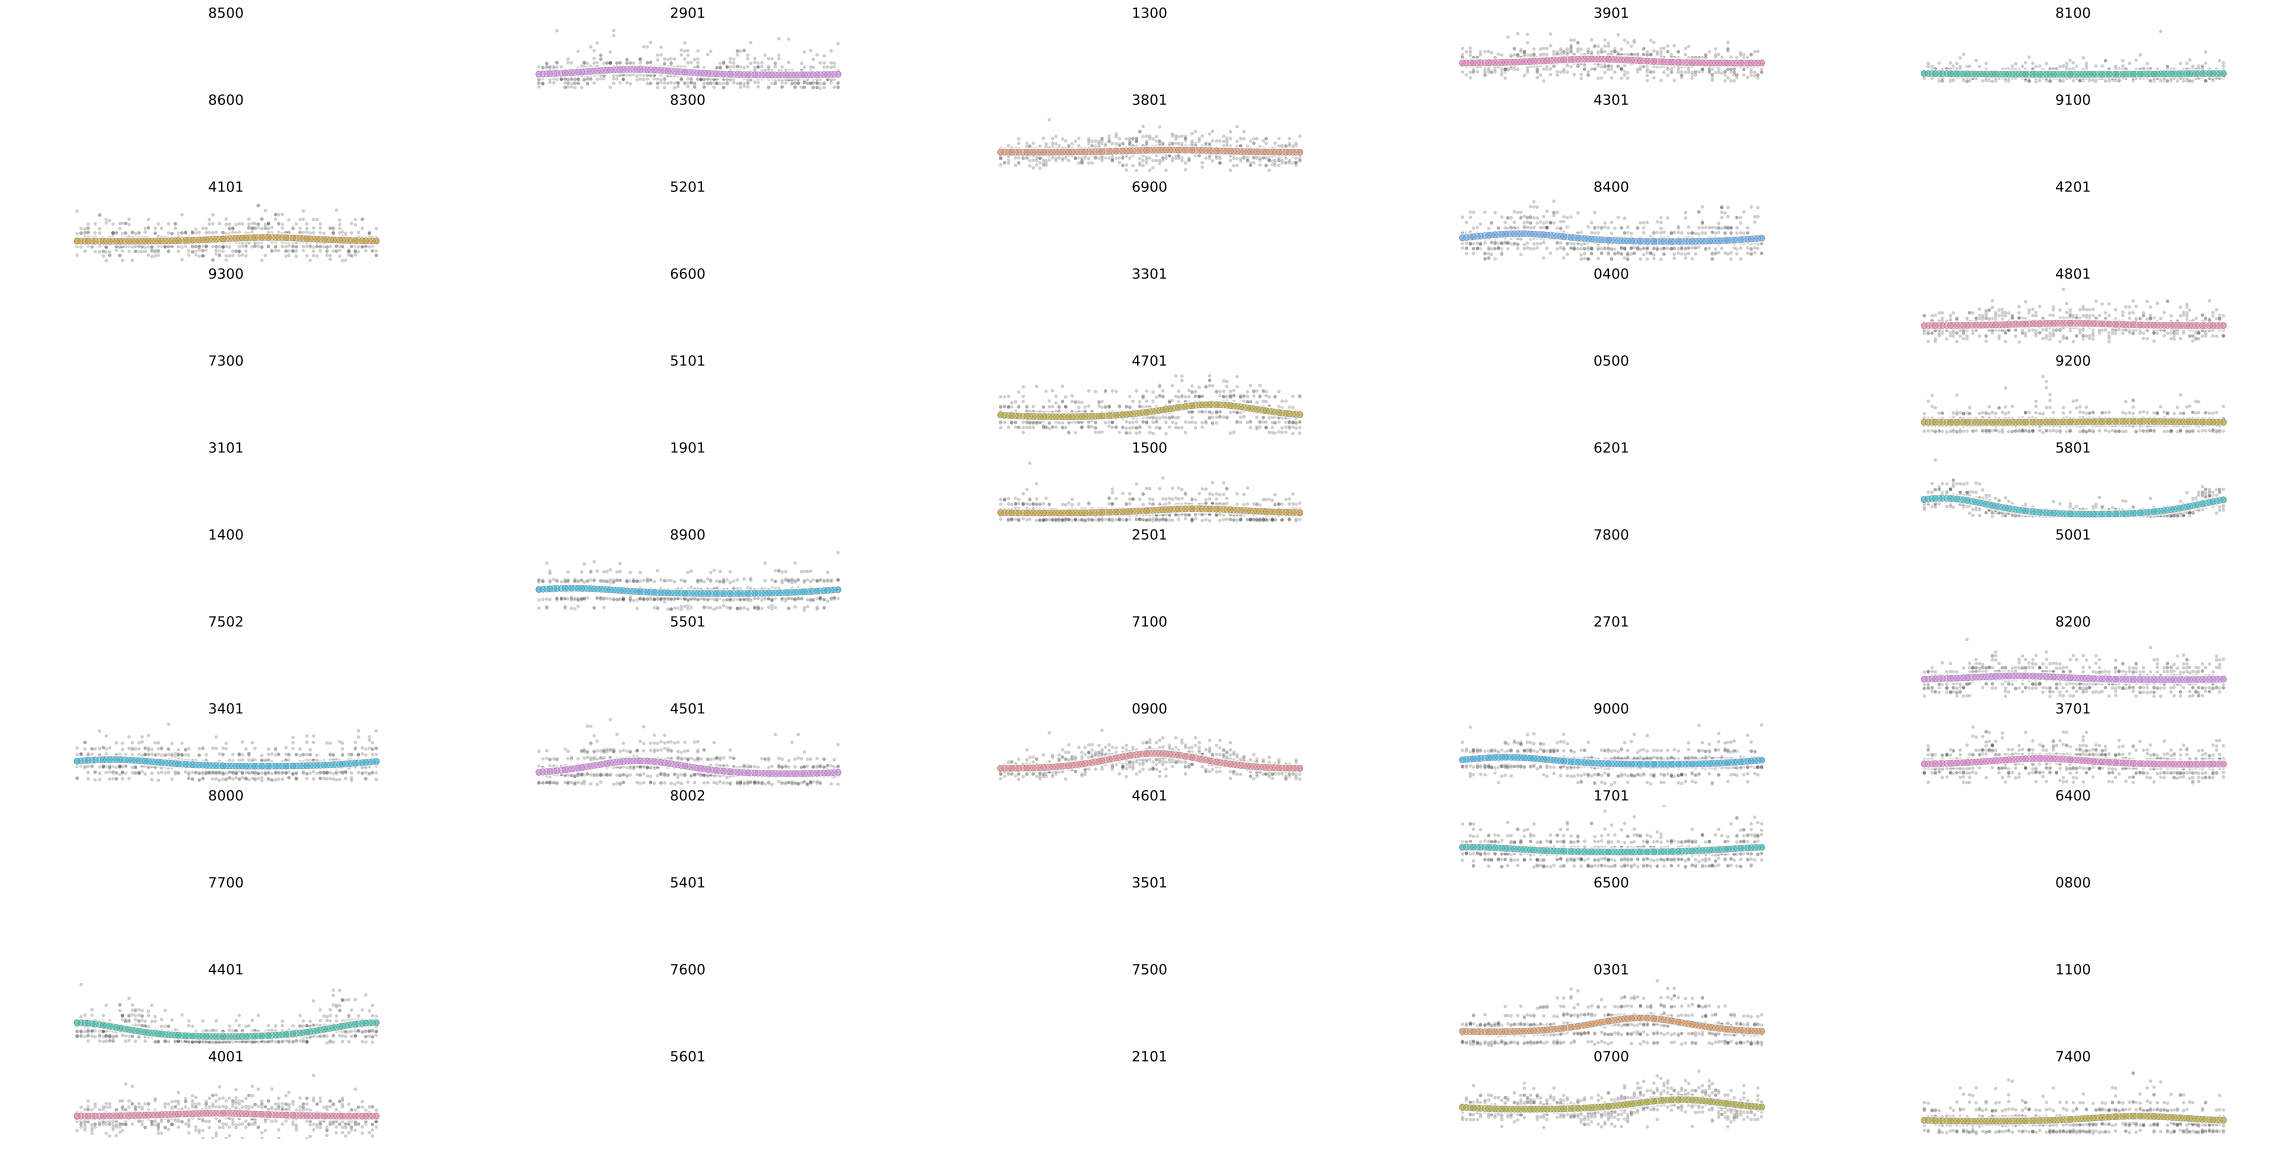

In [144]:
#plt.matplotlib.pyplot.xkcd()
plt.figure(figsize=(40,20))
for n in range(1, n_neurons+1):
    
    plt.subplot(13,5,n, polar=False)
    plt.axis('off')
    neuron_id = ((dat['spikes']).keys())[n-1]
    plt.title(neuron_id, {'fontsize': 14})
        
    # If the neuron has at least 1000 spikes
    if np.sum(Y[:,n-1]) > 1000:
        plt.hold
        plt.plot(hue, Y[:,n-1] + 0.1*np.random.normal(size=n_samples), 'k.', alpha=0.1)
        preferred_hue = hue[(Yhat[:,n-1]).argmax()]
        hue_rgb = hues_to_rgb(preferred_hue)

        plt.plot(hue, Yhat[:,n-1], 'o', alpha = 0.1, color=tuple(hue_rgb[0][0]))

        #plt.xlim(1.2 * np.asarray([-np.pi, np.pi]))
        
        


In [114]:
(Yhat[:,n-1]).argmax()

86

In [116]:
preferred_hue = hue[(Yhat[:,n-1]).argmax()]
hue_rgb = hues_to_rgb(preferred_hue)

In [122]:
tuple(hue_rgb[0][0])

(0.65686744949009146, 0.57085073369936068, 0.0)